# Загрузка Order book из CSV

In [26]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [27]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [46]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-08-1'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [75]:
df_history.shape

(4318228, 11)

In [49]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.399994,3.50655,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.630005,0.03000,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.470001,6.13147,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.329987,4.31794,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:42,NaN,19,binance,ETH/USDT,406.609985,1.71500,None,buy,NaN,disk,2018-09-07 02:20:10.6200000


In [69]:
#перевод в нужные интервалы
interval = 1440 # minutes

#df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()
hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
hist.shape

(74, 2)

In [70]:
hist.fillna(method='ffill', inplace=True)

In [52]:
hist.head()

,price,amount
dt,,
2018-08-07 03:00:00,406.501000,1.378627
2018-08-07 04:00:00,405.592896,7.824664
2018-08-07 05:00:00,405.592896,7.824664
2018-08-07 06:00:00,405.592896,7.824664
2018-08-07 07:00:00,405.592896,7.824664


In [71]:
plt.rcParams['figure.figsize'] = [14, 7]

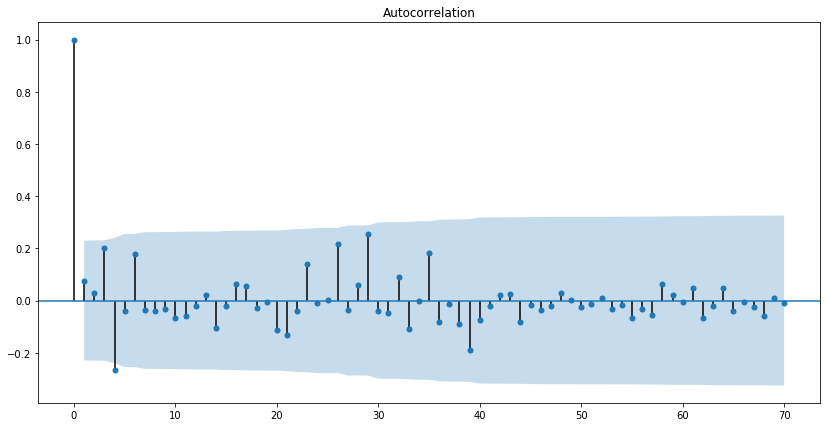

In [74]:
_ = plot_acf(hist[0:len(hist)].price.diff().dropna(), lags=70, alpha=0.05)

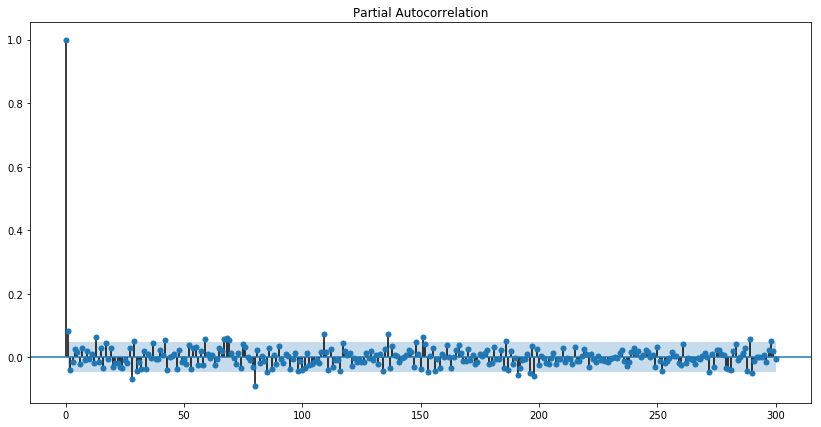

In [59]:
_ = plot_pacf(hist[0:len(hist)].price.diff().dropna(), lags=300, alpha=0.05)

In [60]:
#test-train split

split_point = int(len(hist)*.9)
train, test = hist[0:split_point], hist[split_point:len(hist)]
len(hist), len(train), len(test)

(1758, 1582, 176)

In [61]:
model = ARIMA(train.price, order=(1,1,0))

In [62]:
model_fit = model.fit()

In [63]:
plt.rcParams['figure.figsize'] = [16, 9]

<Figure size 1152x648 with 0 Axes>

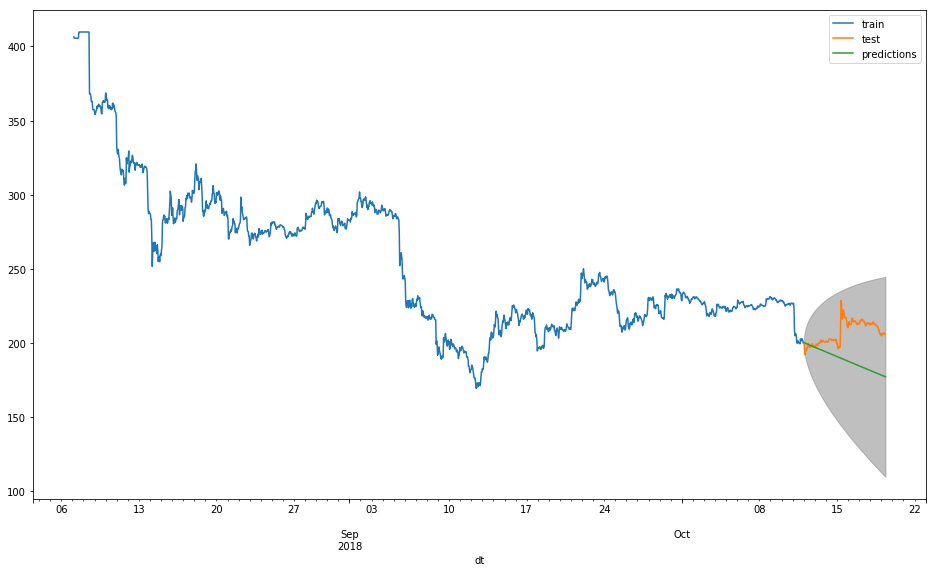

In [64]:
plt.figure()
fig, ax = plt.subplots()

train.price.plot()
test.price.plot(ax=ax)
model_fit.plot_predict(start=len(train), end=len(hist), alpha=0.1, ax=ax)

ax.legend(['train', 'test', 'predictions'])
plt.show()

In [65]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1581
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3908.971
Method:                       css-mle   S.D. of innovations              2.868
Date:                Sun, 21 Oct 2018   AIC                           7823.943
Time:                        21:44:42   BIC                           7840.040
Sample:                    08-07-2018   HQIC                          7829.924
                         - 10-12-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1304      0.077     -1.684      0.092      -0.282       0.021
ar.L1.D.price     0.0690      0.025      2.750      0.006       0.020       0.118
                                    Root

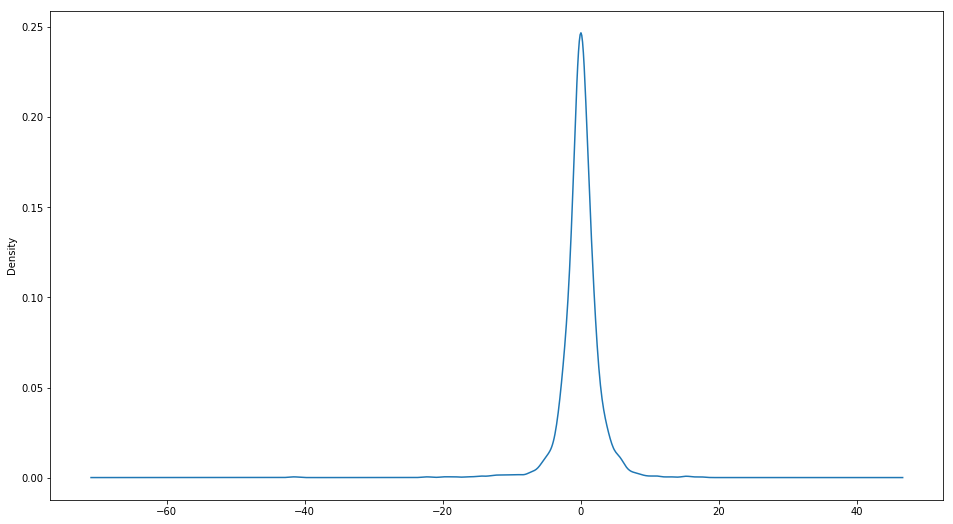

In [66]:
model_fit.resid.plot(kind='kde')

In [67]:
model_fit.resid.describe()

count    1581.000000
mean        0.000034
std         2.868657
min       -41.545770
25%        -0.938732
50%         0.089289
75%         1.115868
max        17.245793
dtype: float64

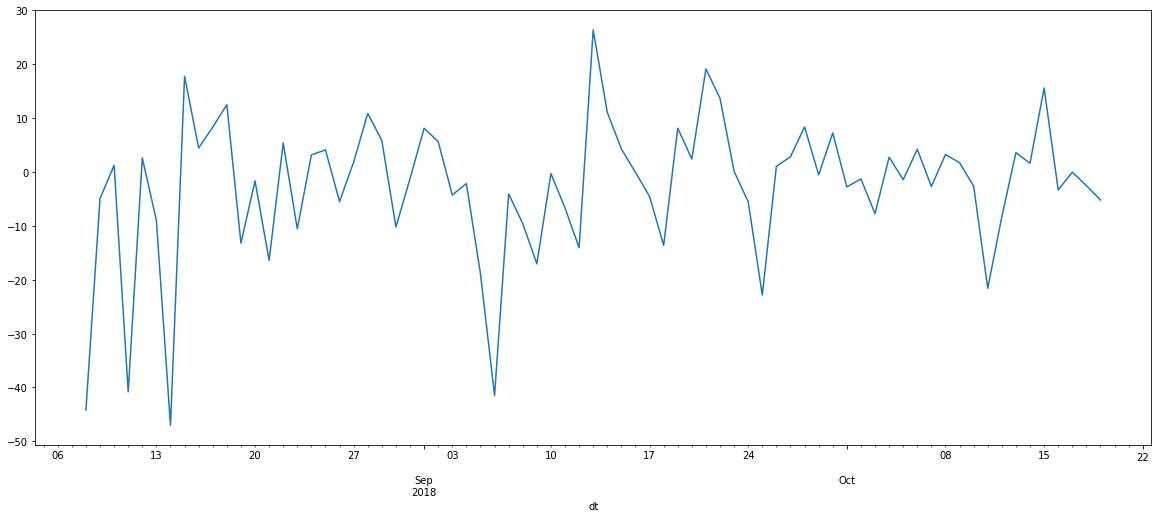

In [68]:
df_history.resample('D').price.mean().diff().plot(figsize=(20,8))